# Assignment 7:  Build a timeseries forcasting model using RNN

# Time series forecasting

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
We are using a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. 

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

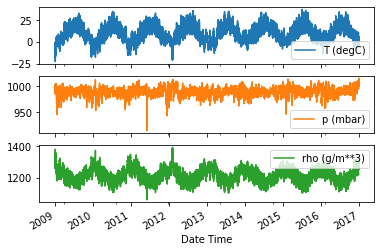

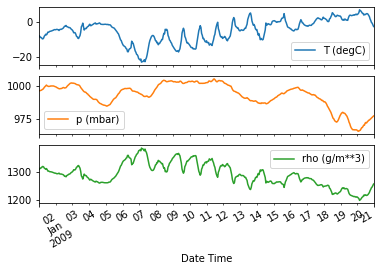

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

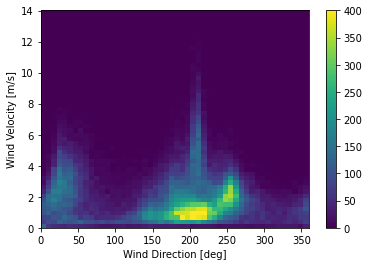

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

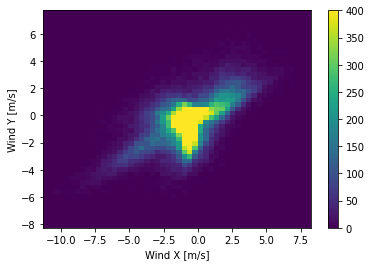

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

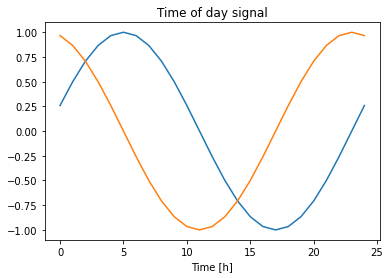

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

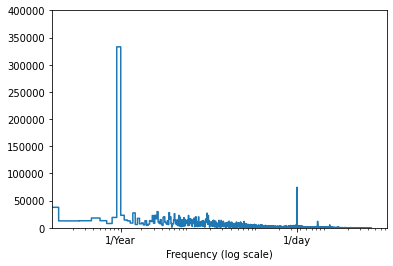

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data


In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

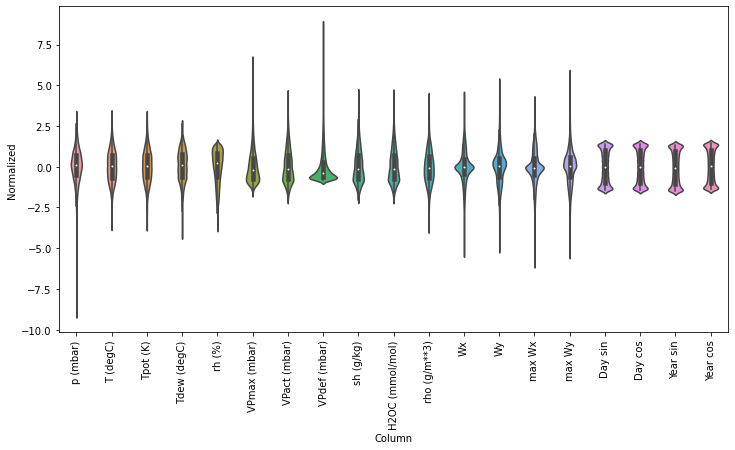

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### 1. Indexes and offsets


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

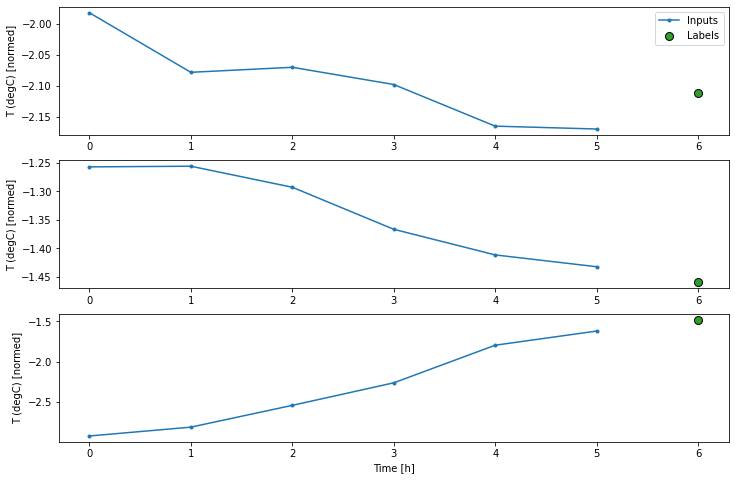

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

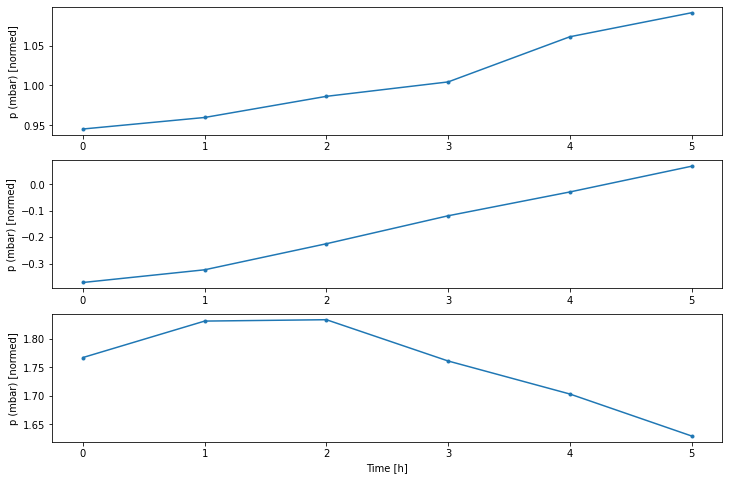

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0789


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

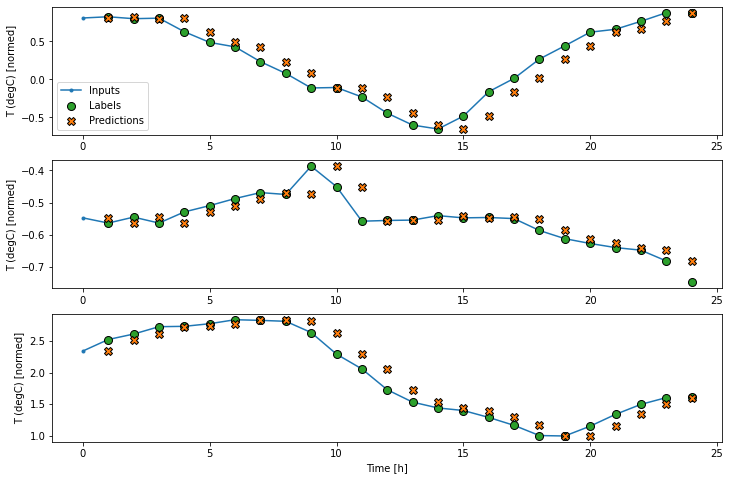

In [ ]:
wide_window.plot(baseline)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 7s 5ms/step - loss: 0.5979 - mean_absolute_error: 0.4968 - val_loss: 0.0135 - val_mean_absolute_error: 0.0863
Epoch 2/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0838 - val_loss: 0.0100 - val_mean_absolute_error: 0.0737
Epoch 3/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0098 - mean_absolute_error: 0.0730 - val_loss: 0.0089 - val_mean_absolute_error: 0.0697
Epoch 4/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0689
Epoch 5/20
1534/1534 [==============================] - 7s 4ms/step - loss: 0.0089 - mean_absolute_error: 0.0692 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 6/20
439/439 [==============================] - 1s 3ms/step - loss: 0.0088 - mean_absolute_error: 0.0697


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

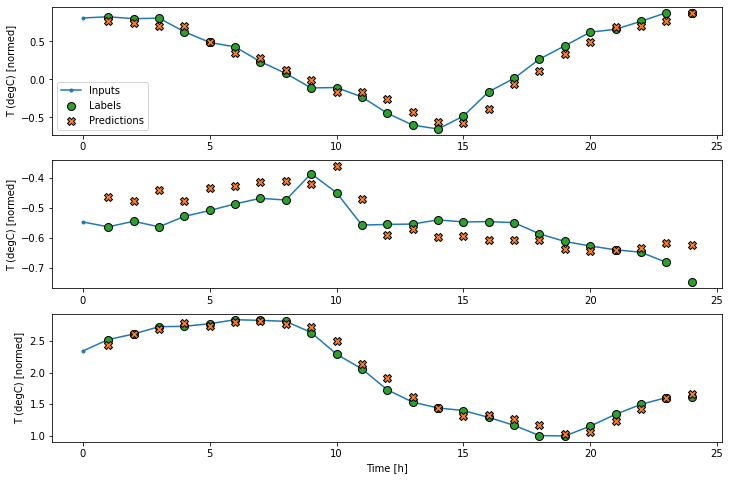

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

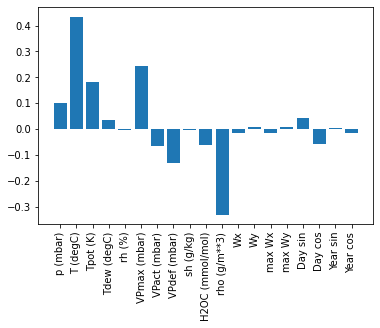

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0528 - mean_absolute_error: 0.1220 - val_loss: 0.0079 - val_mean_absolute_error: 0.0652
Epoch 2/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0080 - mean_absolute_error: 0.0647 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615
Epoch 3/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0075 - mean_absolute_error: 0.0620 - val_loss: 0.0070 - val_mean_absolute_error: 0.0598
Epoch 4/20
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0071 - val_mean_absolute_error: 0.0612
Epoch 5/20
439/439 [==============================] - 2s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0612


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

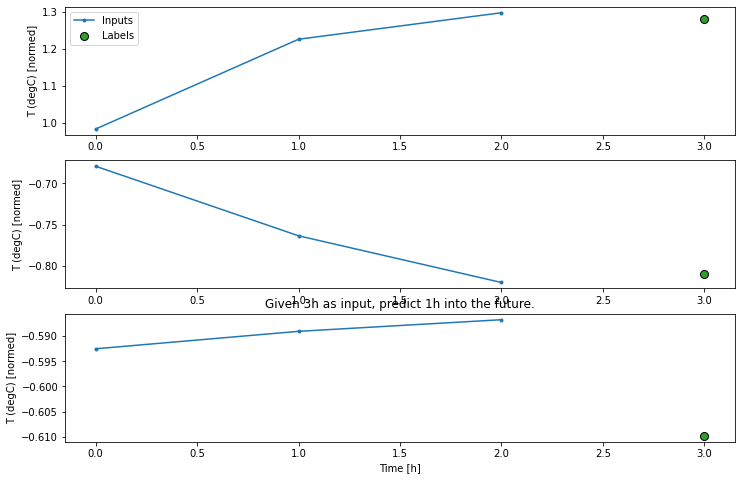

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0612


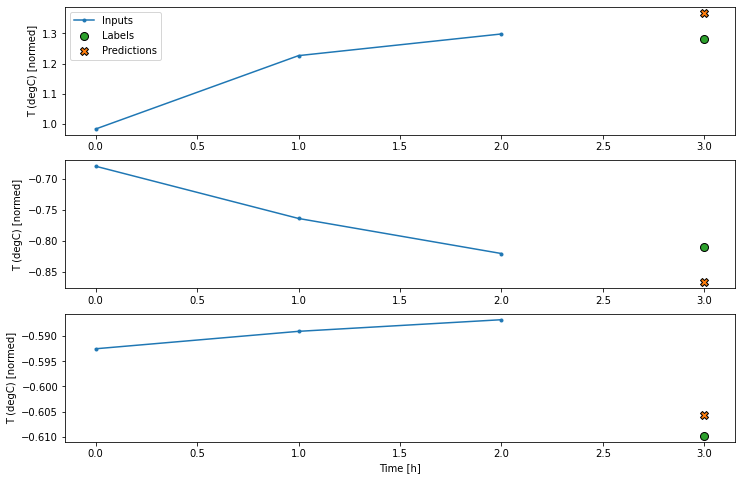

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0063 - mean_absolute_error: 0.0558


In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


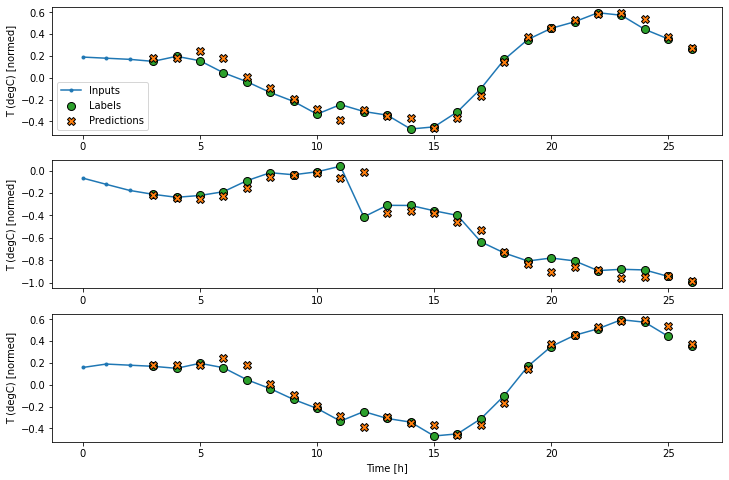

In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0520


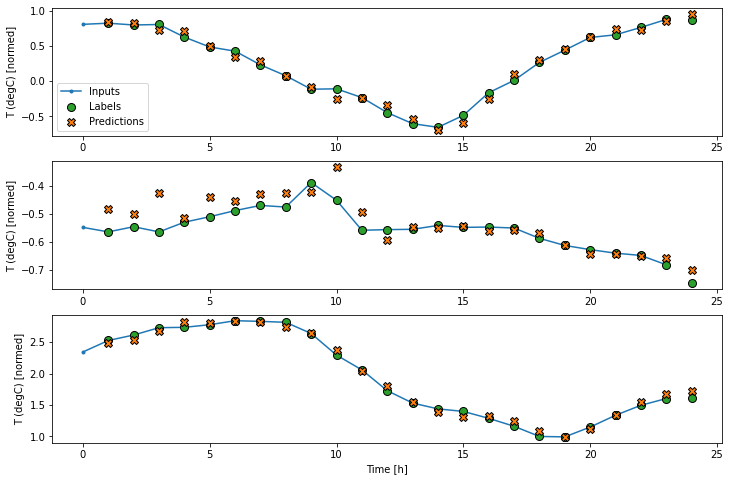

In [ ]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

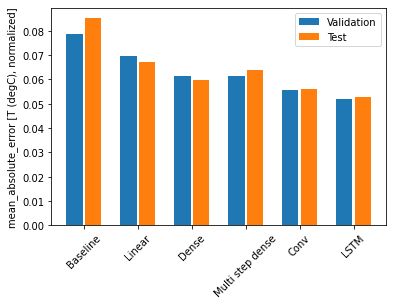

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0673
Dense       : 0.0596
Multi step dense: 0.0637
Conv        : 0.0560
LSTM        : 0.0528


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


#### Baseline


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0888 - mean_absolute_error: 0.1594


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0676 - mean_absolute_error: 0.1294


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 4ms/step - loss: 0.0618 - mean_absolute_error: 0.1206

CPU times: user 3min 58s, sys: 40.4 s, total: 4min 39s
Wall time: 3min 9s


In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 2s 5ms/step - loss: 0.0623 - mean_absolute_error: 0.1182

CPU times: user 1min 16s, sys: 12.4 s, total: 1min 28s
Wall time: 1min


#### Performance

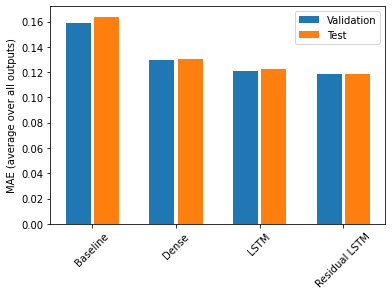

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1300
LSTM           : 0.1223
Residual LSTM  : 0.1188


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

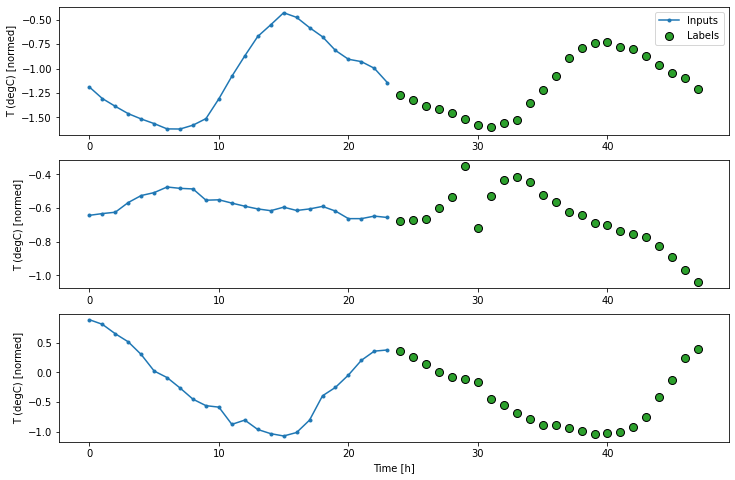

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

437/437 [==============================] - 2s 3ms/step - loss: 0.6278 - mean_absolute_error: 0.5006


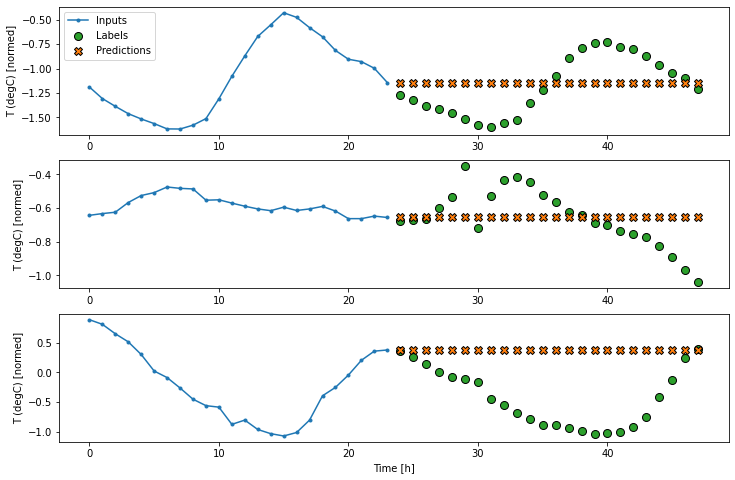

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

437/437 [==============================] - 1s 3ms/step - loss: 0.4265 - mean_absolute_error: 0.3951


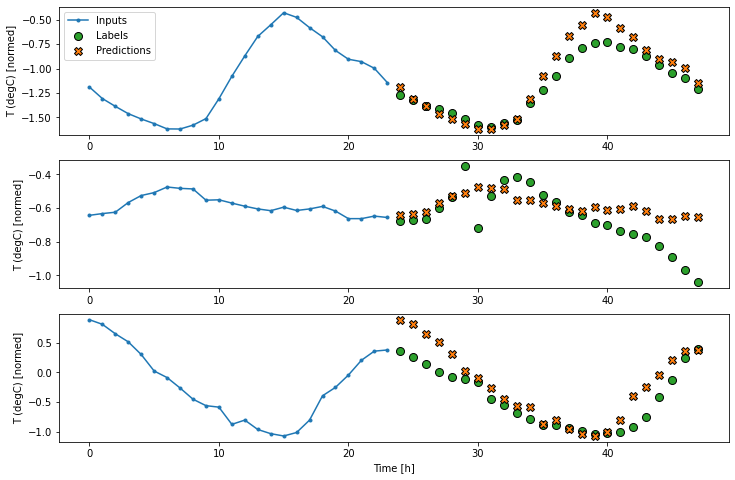

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

437/437 [==============================] - 2s 4ms/step - loss: 0.2552 - mean_absolute_error: 0.3053


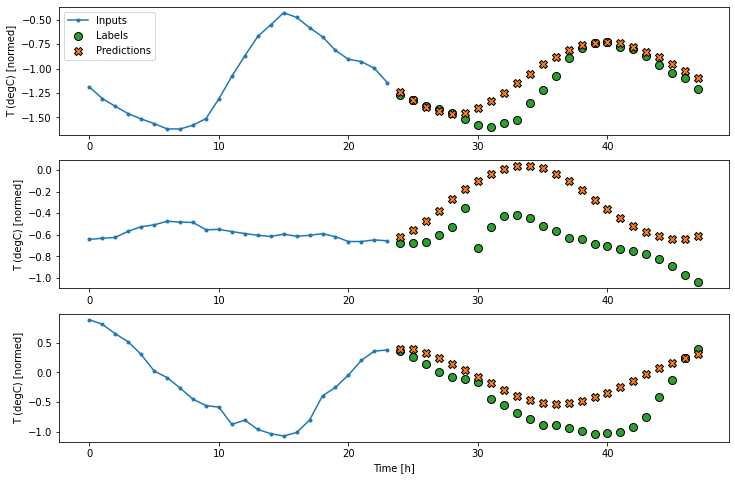

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

437/437 [==============================] - 2s 4ms/step - loss: 0.2199 - mean_absolute_error: 0.2814


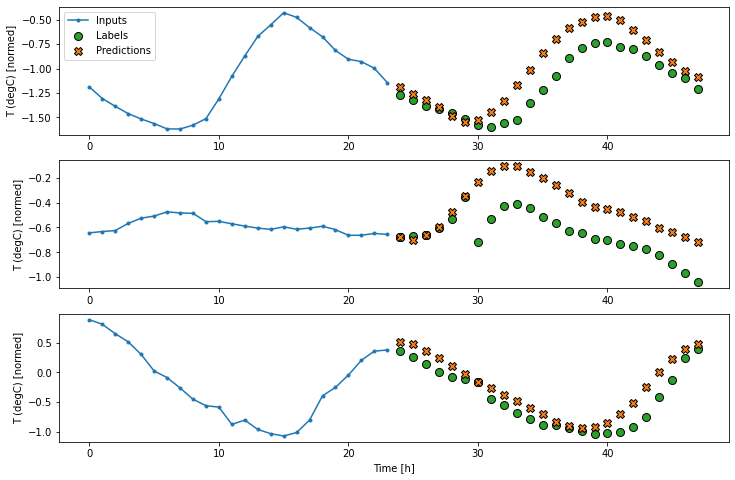

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

437/437 [==============================] - 2s 4ms/step - loss: 0.2148 - mean_absolute_error: 0.2850


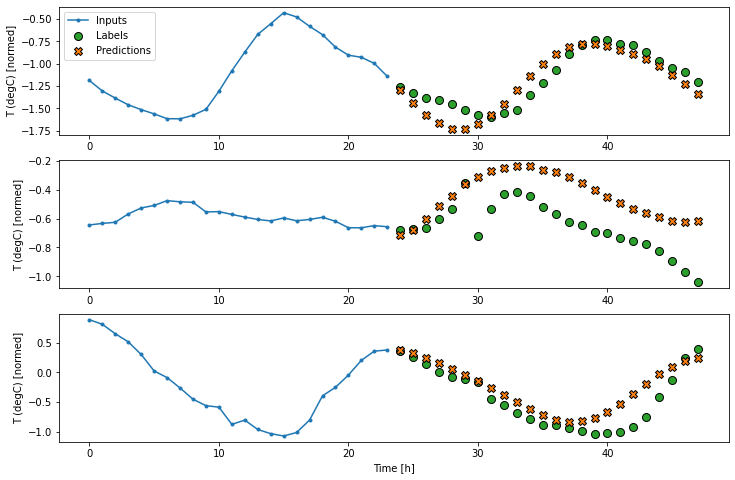

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

437/437 [==============================] - 4s 8ms/step - loss: 0.2270 - mean_absolute_error: 0.2996


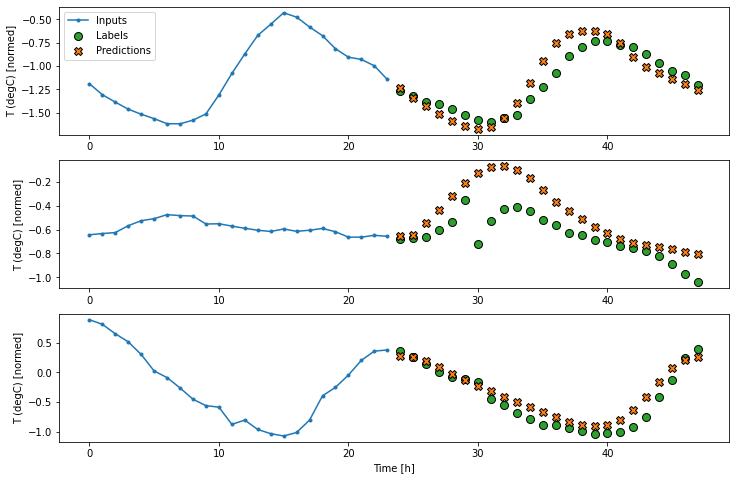

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

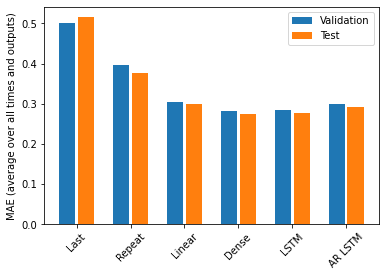

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2742
LSTM    : 0.2769
AR LSTM : 0.2907
